# SMA Crossover Algorithmic Trading Strategy

This is an area to learn some basics of algo trading and backtesting based on a simple smoothed moving average (SMA) crossover strategy.

## Import Libraries
---

In [15]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

## Import Data
---

### Downloading forex data

In [16]:
ticker = 'GBPUSD=X'
yf_data = yf.download(ticker, period='max', interval='1h') # Previous month and the 1 hour time frame - yf.download --> pandas dataframe

lookback = 10000 # looking back at the last n ticks. e.g. 10,000 minutes/hours/days
data = yf_data[-lookback:].copy()

[*********************100%***********************]  1 of 1 completed


In [17]:
data.columns = data.columns.droplevel(1)
# Required to remove the extra 'GPDUSD=X' header for easier handling later on.

data

Price,Close,High,Low,Open,Volume
Datetime,,,,,
2024-05-23 18:00:00+00:00,1.268617,1.270067,1.268617,1.269567,0
2024-05-23 19:00:00+00:00,1.269342,1.269471,1.268617,1.268633,0
2024-05-23 20:00:00+00:00,1.269922,1.269922,1.269293,1.269374,0
2024-05-23 21:00:00+00:00,1.269954,1.270099,1.268939,1.269664,0
2024-05-23 22:00:00+00:00,1.269535,1.269841,1.269535,1.269841,0
...,...,...,...,...,...
2026-01-06 12:00:00+00:00,1.351260,1.352942,1.350968,1.352411,0
2026-01-06 13:00:00+00:00,1.352430,1.352430,1.350749,1.351059,0
2026-01-06 14:00:00+00:00,1.352686,1.353418,1.351644,1.352503,0


### Plot of forex data

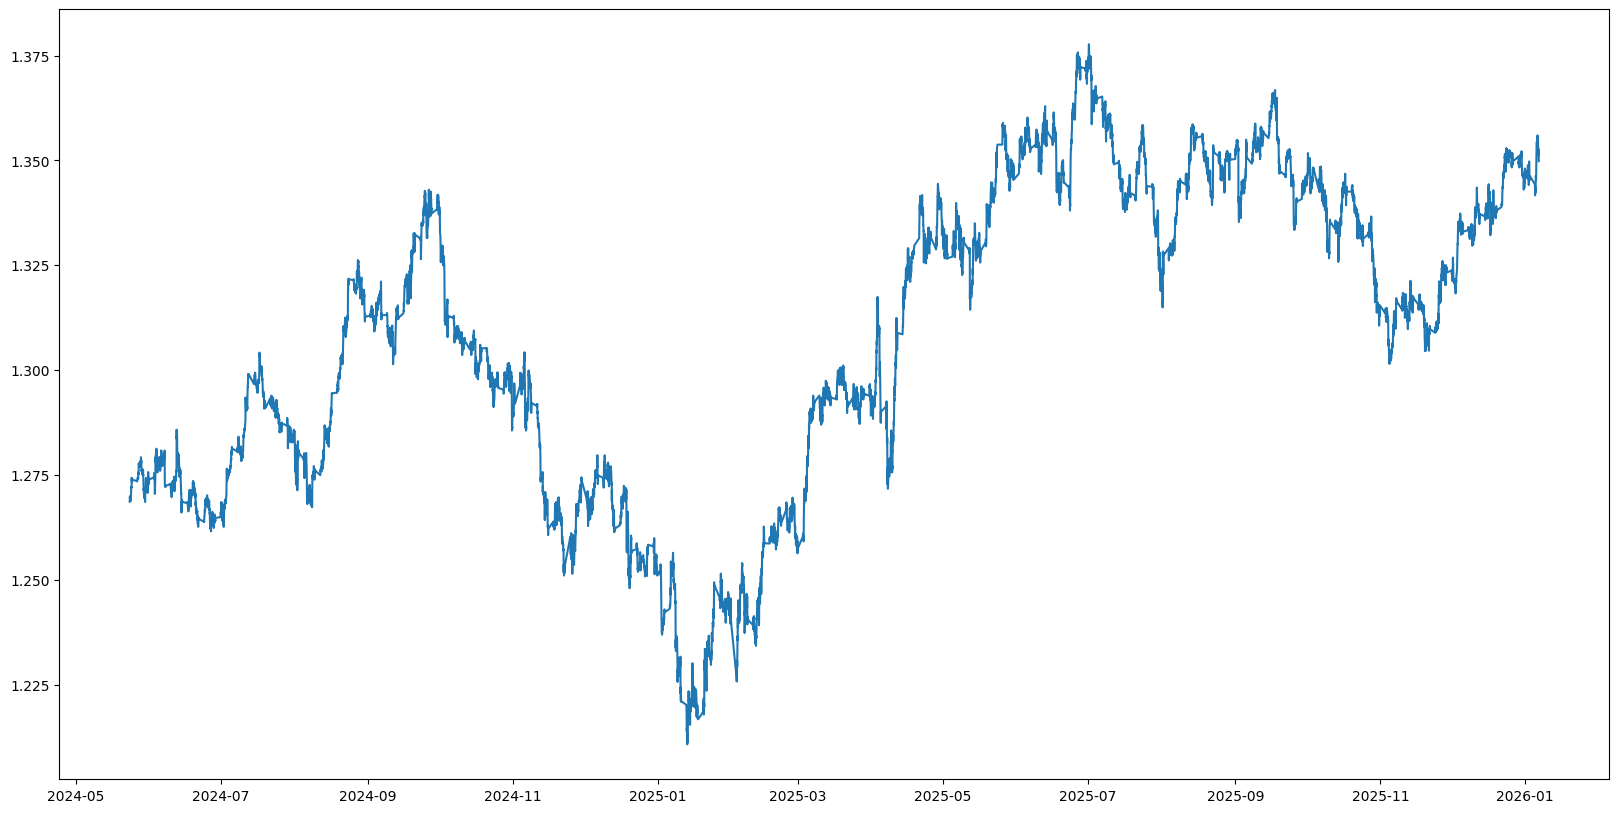

In [18]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(data['Close'])
plt.show()

## Creating Smoothed Moving Averages

---

### Adding moving averages to current data

In [19]:
# Fast and Slow SMA
fast = 10
slow = 27

These are our lookback windows for the SMAs. Fast must be a smaller number than slow so it stays more reactive to recent price movements. These numbers are subject to some experimentation for the 'best' outcome.

In [20]:
data['FastSMA'] = data['Close'].rolling(window=fast).mean()
data['SlowSMA'] = data['Close'].rolling(window=slow).mean()

In [21]:
# Get rid of NaNs

plot_data = data.dropna()
plot_data

Price,Close,High,Low,Open,Volume,FastSMA,SlowSMA
Datetime,,,,,,,
2024-05-24 20:00:00+00:00,1.273820,1.274015,1.273512,1.273983,0,1.273323,1.271028
2024-05-24 21:00:00+00:00,1.273902,1.273902,1.273902,1.273902,0,1.273521,1.271224
2024-05-26 23:00:00+00:00,1.273463,1.274161,1.273463,1.274161,0,1.273657,1.271376
2024-05-27 00:00:00+00:00,1.273837,1.273934,1.273447,1.273447,0,1.273827,1.271521
2024-05-27 01:00:00+00:00,1.274177,1.274210,1.273885,1.273934,0,1.273866,1.271678
...,...,...,...,...,...,...,...
2026-01-06 12:00:00+00:00,1.351260,1.352942,1.350968,1.352411,0,1.354325,1.352532
2026-01-06 13:00:00+00:00,1.352430,1.352430,1.350749,1.351059,0,1.353973,1.352759
2026-01-06 14:00:00+00:00,1.352686,1.353418,1.351644,1.352503,0,1.353680,1.353007


### Plotting Moving Averages

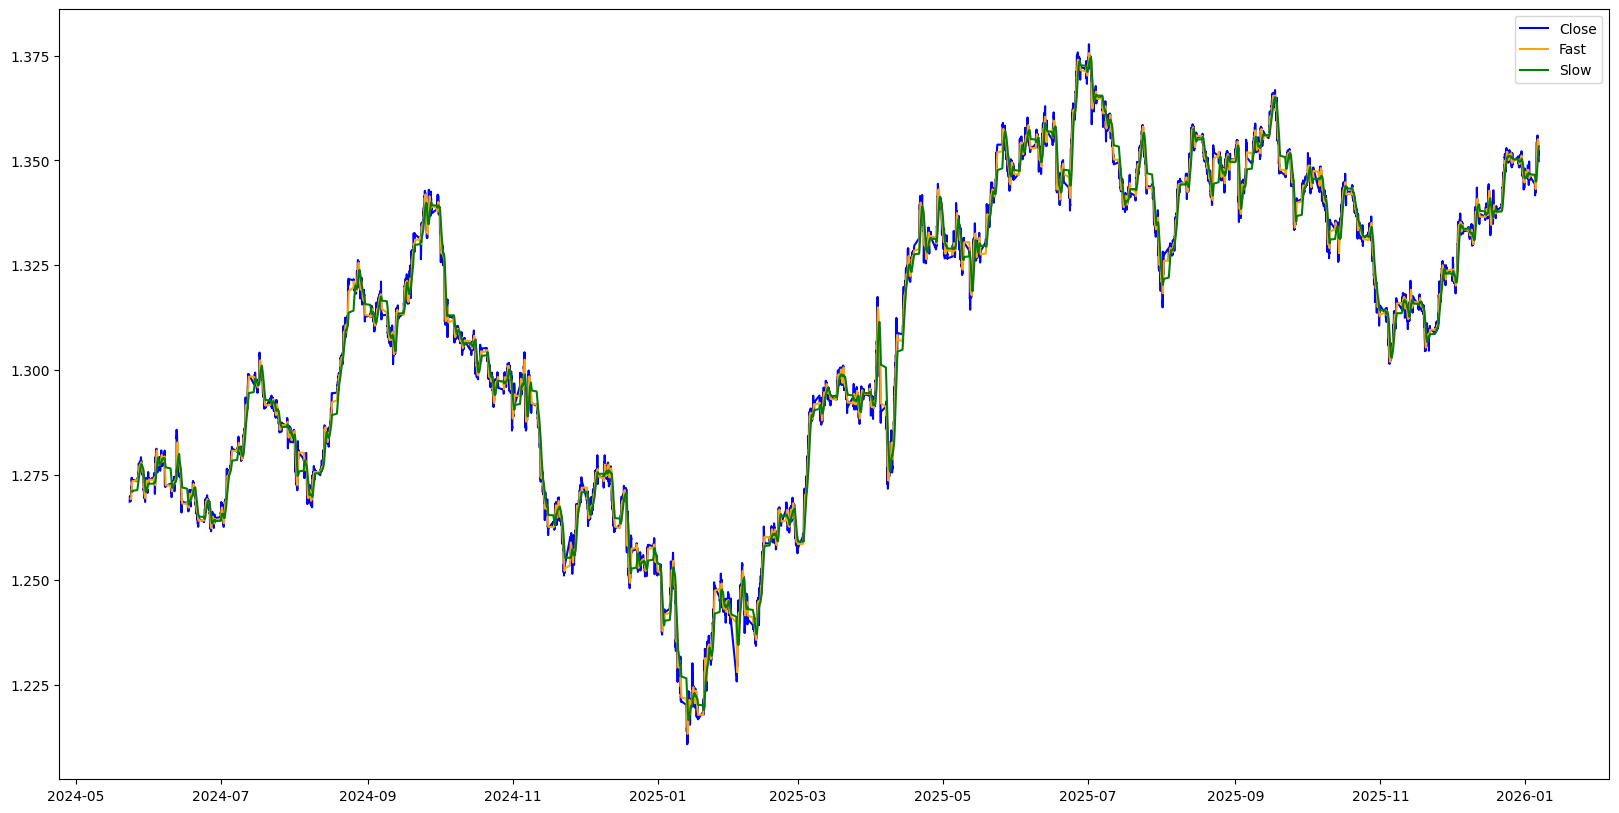

In [22]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(data['Close'], color='blue', label='Close')
ax.plot(data['FastSMA'], color='orange', label='Fast')
ax.plot(data['SlowSMA'], color='green', label='Slow')
ax.legend()
plt.show()

Looking at the plot we can see the fast SMA line (orange) frequently crosses above and below our slow line. The idea behind this strategy is to buy when the fast line crosses about the slow line and sell when the inverse happens.

## Strategy
---

### Finding crossovers

In [23]:
data['Strategy'] = np.where(data['FastSMA'] > data['SlowSMA'], 1, -1)
# crossovers will show as 1 (fast above slow) and -1 (slow above fast)

data['Strategy'] = data['Strategy'].shift(1)
# strategy data must be shifted over once as we don't know the closing prices (and therefore SMAs) until they've closed.

### Does it work?

In [24]:
data['Strategy_Returns'] = (1 + data['Close'].pct_change() * data['Strategy']).cumprod() - 1
data['Asset_Returns'] = (1 + data['Close'].pct_change()).cumprod() -1

data

Price,Close,High,Low,Open,Volume,FastSMA,SlowSMA,Strategy,Strategy_Returns,Asset_Returns
Datetime,,,,,,,,,,
2024-05-23 18:00:00+00:00,1.268617,1.270067,1.268617,1.269567,0,NaN,NaN,NaN,NaN,NaN
2024-05-23 19:00:00+00:00,1.269342,1.269471,1.268617,1.268633,0,NaN,NaN,-1.0,-0.000571,0.000571
2024-05-23 20:00:00+00:00,1.269922,1.269922,1.269293,1.269374,0,NaN,NaN,-1.0,-0.001028,0.001029
2024-05-23 21:00:00+00:00,1.269954,1.270099,1.268939,1.269664,0,NaN,NaN,-1.0,-0.001053,0.001054
2024-05-23 22:00:00+00:00,1.269535,1.269841,1.269535,1.269841,0,NaN,NaN,-1.0,-0.000724,0.000724
...,...,...,...,...,...,...,...,...,...,...
2026-01-06 12:00:00+00:00,1.351260,1.352942,1.350968,1.352411,0,1.354325,1.352532,1.0,0.041679,0.065144
2026-01-06 13:00:00+00:00,1.352430,1.352430,1.350749,1.351059,0,1.353973,1.352759,1.0,0.042581,0.066066
2026-01-06 14:00:00+00:00,1.352686,1.353418,1.351644,1.352503,0,1.353680,1.353007,1.0,0.042778,0.066268


In [25]:
plot_data = data.dropna()

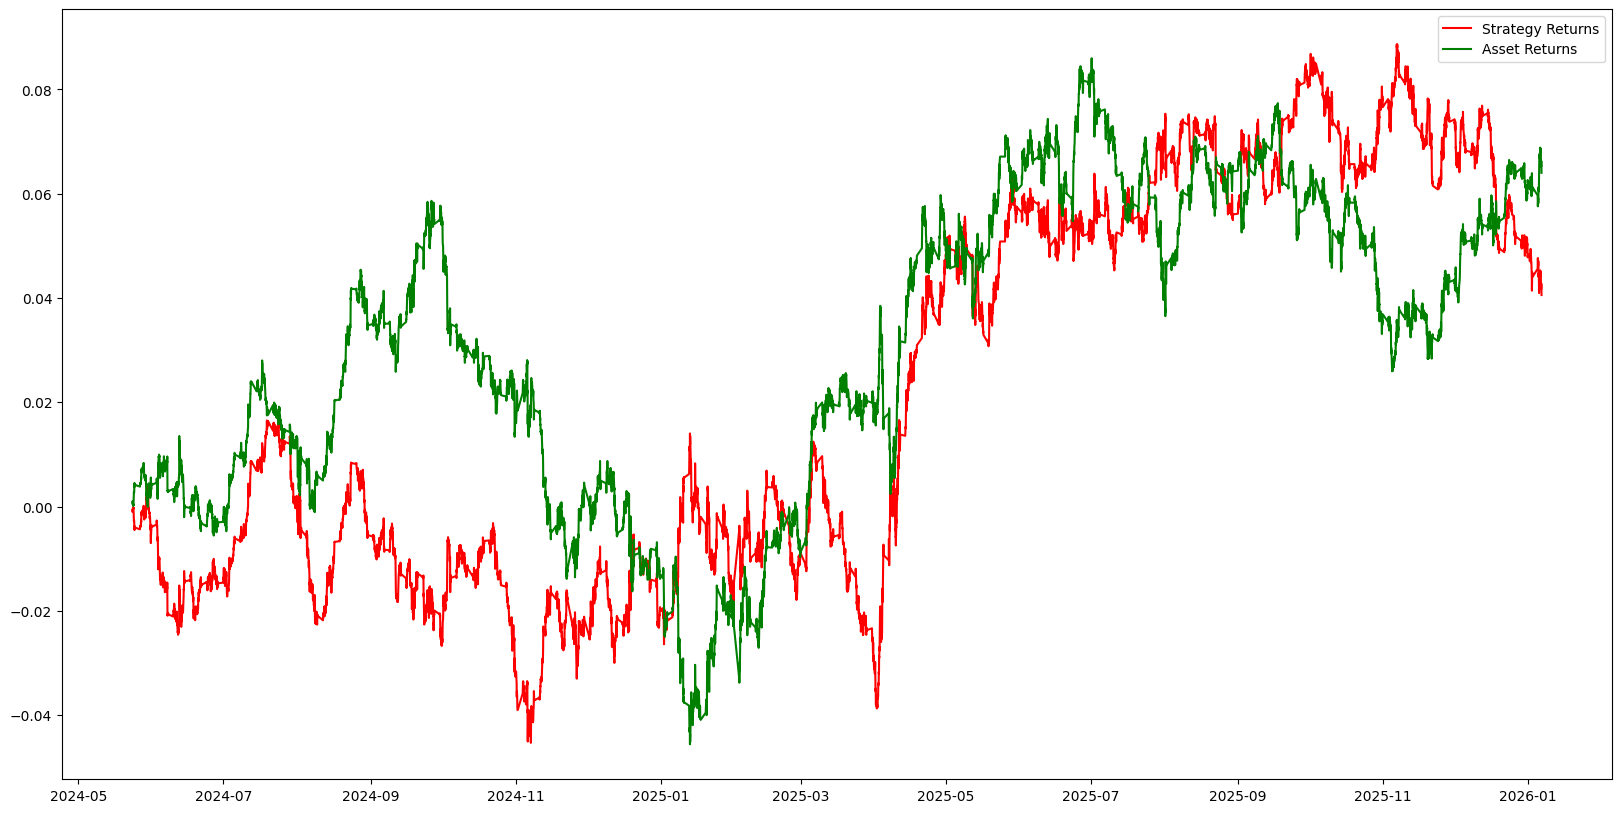

In [26]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(data['Strategy_Returns'], color='Red', label='Strategy Returns')
ax.plot(data['Asset_Returns'], color='Green', label='Asset Returns')
ax.legend()
plt.show()

What we see is that with a fast of 10 and a slow of 27 there are some promising areas but overall the strategy does not work. However, there is definetley room to experiment with different time frames and lookback windows for our SMAs.

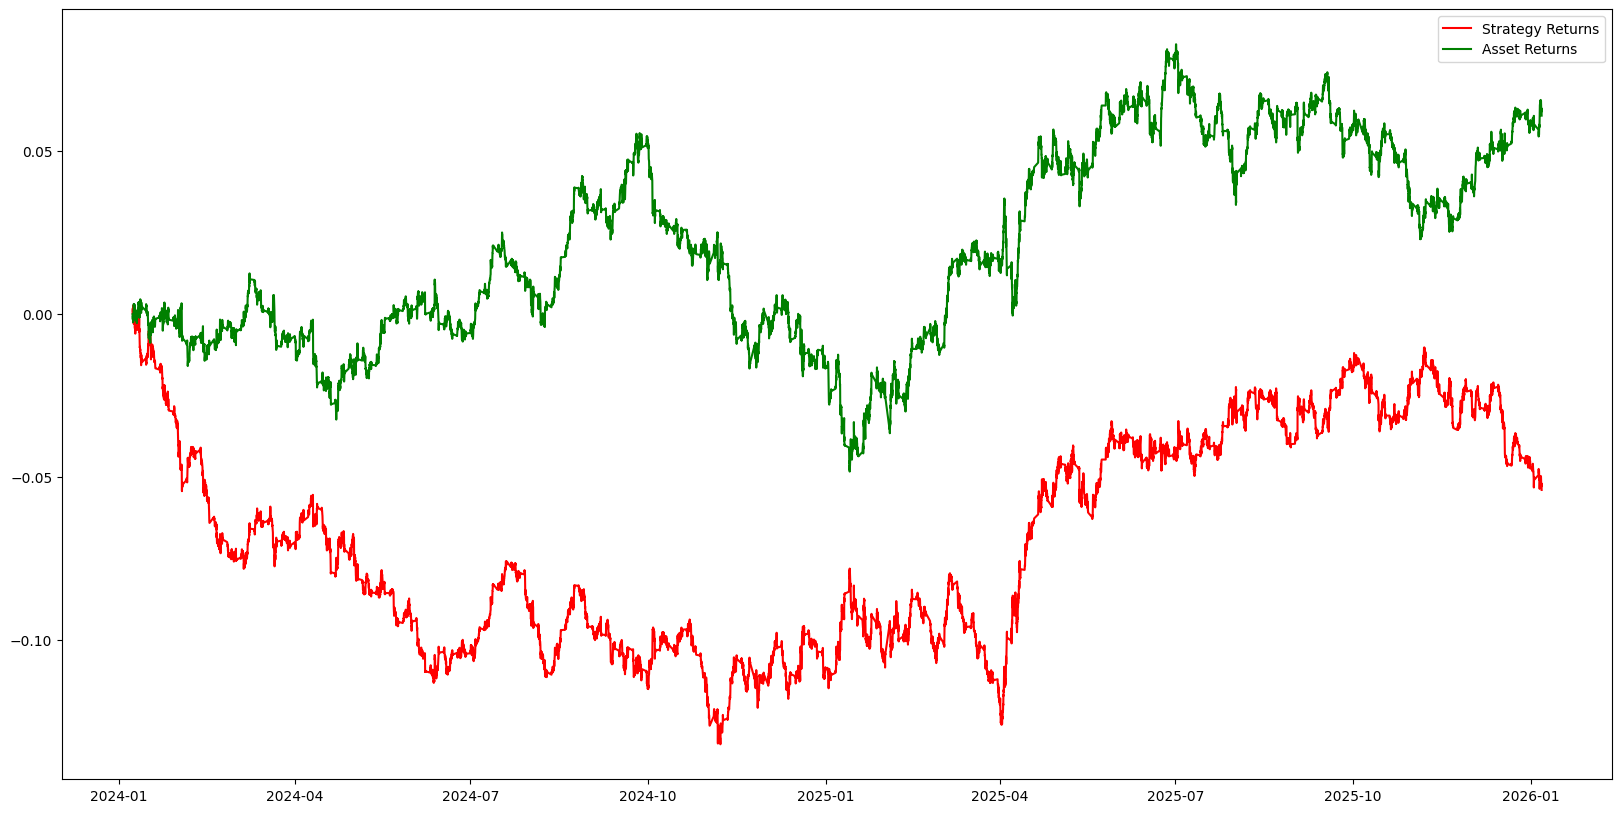

In [27]:
data = yf_data
data.columns = data.columns.droplevel(1)

data['FastSMA'] = data['Close'].rolling(window=fast).mean()
data['SlowSMA'] = data['Close'].rolling(window=slow).mean()

data['Strategy'] = np.where(data['FastSMA'] > data['SlowSMA'], 1, -1)
data['Strategy'] = data['Strategy'].shift(1)

data['Strategy_Returns'] = (1 + data['Close'].pct_change() * data['Strategy']).cumprod() - 1
data['Asset_Returns'] = (1 + data['Close'].pct_change()).cumprod() -1

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(data['Strategy_Returns'], color='Red', label='Strategy Returns')
ax.plot(data['Asset_Returns'], color='Green', label='Asset Returns')
ax.legend()
plt.show()

If we backtest as far back as we can go we see that the strategy isn't very good at all.